---
## Converting an image from RGB to HSV and back to RGB.
---

In [12]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Total Images : 45


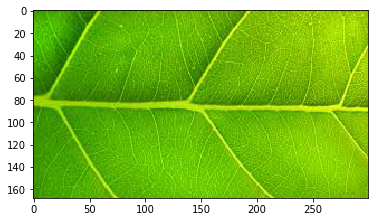

In [13]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
images = load_images_from_folder('./image')
print("Total Images : {}".format(len(images)))
images_rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]
plt.imshow(images_rgb[21])

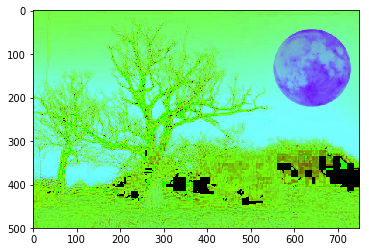

In [14]:
images_hsv = [cv2.cvtColor(image, cv2.COLOR_BGR2HSV) for image in images]
plt.imshow(images_hsv[35])

---
## The equations for conversion
---

```

Cmax = max(R', G', B')

Cmin = min(R', G', B')

delta = Cmax - Cmin
```

_Computing HSV values:_

```
HUE
- 0, if delta = 0
- 60 * (G' - B') * mod6 / delta, if Cmax = R'
- 60 * (B' - R') + 2 / delta, if Cmax = G'
- 60 * (R' - G') + 4 / delta, if Cmax = B'

SATURATION
- 0, if Cmax = 0
- delta/cmax, if Cmax = 0

Value
- Cmax
```
 

---
## Are they perceptually same?
---

While amounts in HSV are not completely relevant for telling a display how much within each RGB channel is required, it creates a scale that describes useful properties of colour. And at the end of the day, it's returned as RGB or hexadecimal; merely a different way to break down colour components into locations within a given colour gamut.
HSV doesn't scale to all digital colour spaces, but in most cases you should be able to flip over from the RGB scale. Being able to apply traditional approaches in picking and applying colour opens up a more fluid and natural work flow, which can assist the transition for traditional artists migrating into the digital realm. So HSV or RGB as a colour refining scale? Obviously HSV! Get into the habit of tweaking colour with the HSV sliders

---
## Showing the RGB and HSV values of (100,100) pixel
---

In [15]:
print("Image dimension : {}".format(images_hsv[0].shape))
print("Red: {}".format(images_rgb[0][100,100,0]))
print("Blue: {}".format(images_rgb[0][100,100,1]))
print("Green: {}".format(images_rgb[0][100,100,2]))
print("Hue: {}".format(images_hsv[0][100,100,0]))
print("Saturation: {}".format(images_hsv[0][100,100,1]))
print("Value: {}".format(images_hsv[0][100,100,2]))

Image dimension : (177, 284, 3)
Red: 45
Blue: 69
Green: 9
Hue: 42
Saturation: 222
Value: 69


---
### Implementing a CBIR system that uses features derived from Color Space

### Database – 60 images and 3 categories – Red Dominant, Green
### Dominant, Blue Dominant (20 images from each category)
### Query Image – 1
### Search Result – 10
### i. Dimension of the images as features
### ii. Mean of the Color Channels as features
### iii. Moment of the Color Channels as features
---

---
## 1) Image Dimensions Column
---

In [16]:
def get_dimension(image):
    return image.shape

In [17]:
def get_mean(img):
    mean_red = img[:,:,0].mean()
    mean_blue = img[:,:,1].mean()
    mean_green = img[:,:,2].mean()
    return (mean_red, mean_blue, mean_green)

def get_moment(img):
    moment_red = cv2.moments(img[:,:,0])['m00']
    moment_blue = cv2.moments(img[:,:,1])['m00']
    moment_green = cv2.moments(img[:,:,2])['m00']
    return (moment_red, moment_blue, moment_green)

imageDB = pd.DataFrame()
imageDB['image_matrix'] = images_rgb
imageDB['dimension'] = imageDB['image_matrix'].apply(get_dimension)
imageDB['mean'] = imageDB['image_matrix'].apply(get_mean)
imageDB['moment'] = imageDB['image_matrix'].apply(get_moment)

In [18]:
def euclidean_distance(x=(0,0,0), y=(0,0,0)):
    return np.sqrt(np.square(x[0] - y[0]) 
                   + np.square(x[1] - y[1])
                   + np.square(x[2] - y[2]))

def get_similarity(query_img, DB):
    dimension = get_dimension(query_img)
    mean = get_mean(query_img)
    moment = get_moment(query_img)
    similarity_dimension = DB['dimension'].map(lambda x : euclidean_distance(dimension, x))
    similarity_mean = DB['mean'].map(lambda x : euclidean_distance(mean, x))
    similarity_moment = DB['moment'].map(lambda x : euclidean_distance(moment, x))
    return (similarity_dimension, similarity_mean, similarity_moment)

def query(query_img, DB, by='mean', rank=10):
    if by == 'dimension':
        dimension = get_dimension(query_img)
        similarity_dimension = DB['dimension'].map(lambda x : euclidean_distance(dimension, x))
        similarity_dimension = similarity_dimension.to_dict()
        similar_images_dimension = sorted(similarity_dimension, key=similarity_dimension.get)
        
        f, axarr = plt.subplots(rank, sharex=True, figsize=(10,20))
        f.suptitle('Similar Images by Dimension')
        for i in range(rank):
            similar_image = similar_images_dimension[i]
            axarr[i].imshow(imageDB.iloc[similar_image][0])
    
    elif by == 'mean':
        mean = get_mean(query_img)
        similarity_mean = DB['mean'].map(lambda x : euclidean_distance(mean, x))
        similarity_mean = similarity_mean.to_dict()
        similar_images_mean = sorted(similarity_mean, key=similarity_mean.get)

        f, axarr = plt.subplots(rank, sharex=True, figsize=(10,20))
        f.suptitle('Similar Images by Mean Color')
        for i in range(rank):
            similar_image = similar_images_mean[i]
            axarr[i].imshow(imageDB.iloc[similar_image][0])

    elif by == 'moment':
        # taking measures of the query image
        moment = get_moment(query_img)
        # finding the similarity measure
        similarity_moment = DB['moment'].map(lambda x : euclidean_distance(moment, x))
        # sorting the similar images
        similarity_moment = similarity_moment.to_dict()
        similar_images_moment = sorted(similarity_moment, key=similarity_moment.get)[:rank]
        # displaying the similar images
        f, axarr = plt.subplots(rank, sharex=True, figsize=(10,30))
        f.suptitle('Similar Images by Color Moment')
        for i in range(rank):
            similar_image = similar_images_moment[i]
            axarr[i].imshow(imageDB.iloc[similar_image][0])

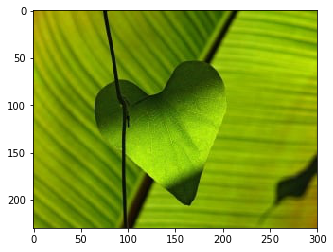

In [24]:
plt.imshow(images_rgb[34])

---
## QUERING BY MOMENT
---

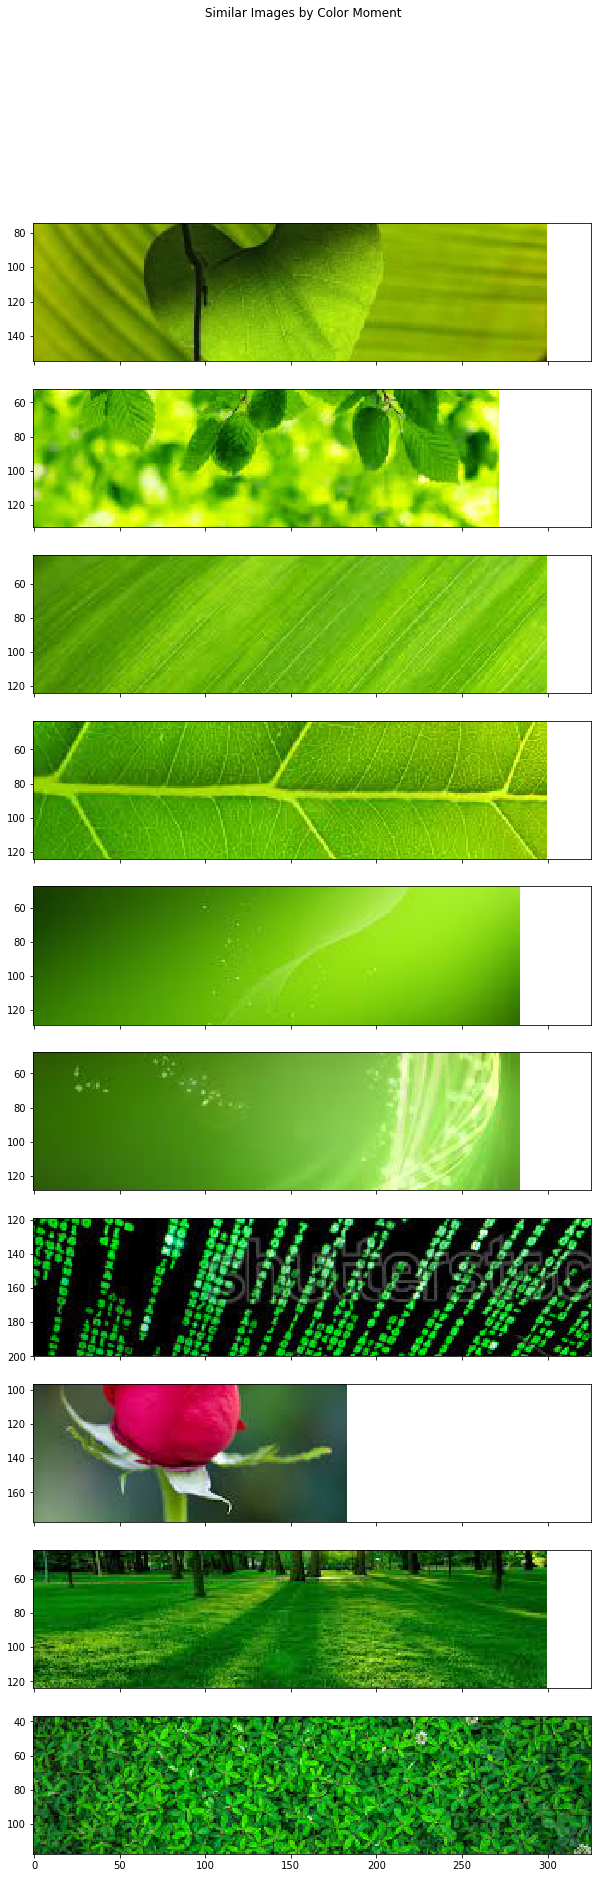

In [25]:
query(images_rgb[34],imageDB, by='moment', rank=10)

---
## QUERING BY MEAN
---

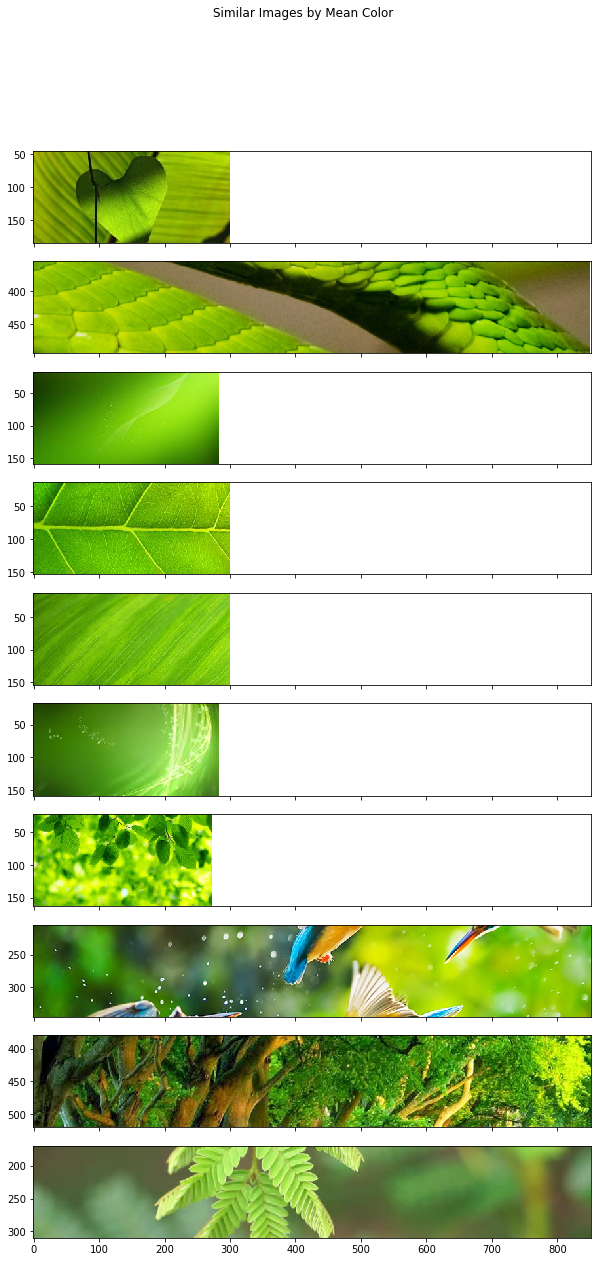

In [26]:
query(images_rgb[34],imageDB, by='mean', rank=10)

---
## QUERING BY DIMENSION
---

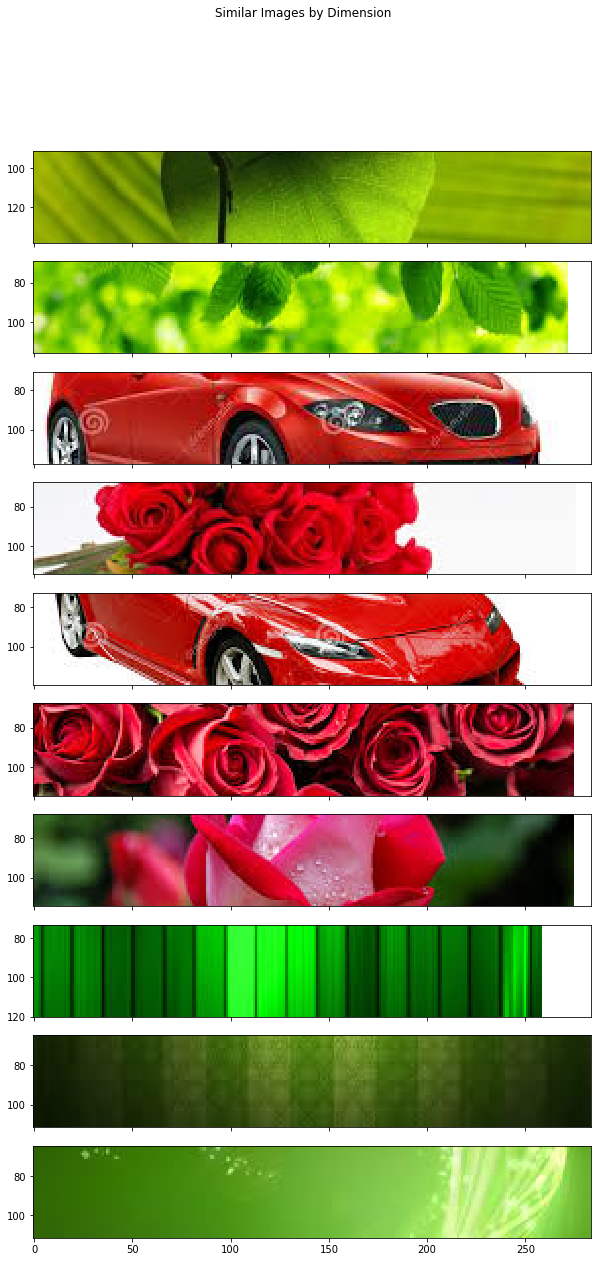

In [28]:
query(images_rgb[34],imageDB, by='dimension', rank=10)

---
##### Study about some CBIR Engines work on how they work:
##### a. Akiwi
##### b. Chic Engine
##### c. Image Hunter
##### d. Baidu Image Search
##### e. Yandex Image Search
##### f. Google Image Search

##### And which one is the best.
---

**Akiwi** - is a new website that’s designed to help you keyword photographs with minimal effort. It’s a semi-automated image tagging system that is easier than manually tagging and more accurate than automatic image recognition.
STEPS INVOLVED: 
1). You’ll be asked to drag and drop an image in the search interface.
2). After uploading AKIWI shows collection of similar looking photographs and some keywords based on the image you’ve uploaded.
3). Your job is to select the most relevant images and keywords from the suggestions.
4). The goal of the system is that with just a few clicks of your mouse (and no key presses), you’ll have a relevant and accurate set of keywords.

**Chic Engine**- A smarter, faster, and easier to use fashion search engine where you search using images rather than keywords. This analyzes images rather than the text of the webpage they appear on. 
Users can utilize the search engine to find pieces of clothing that appeals to them personally by providing an example image of the clothing (or fabric) they are interested in. Other search engines on the web do not yet have a visual search component. Chic Engine is aiming to be the first successful visual search engine online focusing in the fashion area. 
Ex - When you upload a picture of a blue shirt, find all the blue shirts for you. No more guessing the right combinations of keywords to find what you want. 

***Image Hunter***- image Hunter is a prototype Content Based Image Retrieval system joint developed with the Ambient Intelligence Laboratory (Sardegna Ricerche). The system performs Query by Example searches, that can be interactively refined by Relevance Feedback mechanisms.
In general, this first stage doesn't provide high relevant results because it is an hard task to model the similarity semantic through low level visual features. At this stage the user can submit to the system a feedback, this feedback represents the relevance of the image with respect of the semantic desired. The system implements two degrees of relevance: relevant, not relevant.
These relevance degrees are subdued to the system that, after a computation, rearrange the research previously made in a way to present to the user more relevant images. In this way it is possible to find similar images in tagged images databases, and, above all, in not-tagged images databases or with meaningless keyword.

**Google Image Search**-  Google's Search by image is a feature that utilizes reverse image search and allows users to search for related images just by uploading an image or image URL. Google accomplishes this by analyzing the submitted picture. It is then compared with billions of other images in Google's databases before returning matching and similar results. It should be noted that when available, Google also uses metadata about the image such as description.

**Baidu Image Search**-  Baidu introduced "phonetic" or "pin-yin" search, which allows users to type in Chinese keywords using English alphabets. This feature is designed to skip the switching from English input to Chinese input, and for when the user is not sure of the written form of a keyword. Since there are many different ways to pronounce and state common words, and many different dialects, this was a huge addition for the search engine which greatly set it apart from all other search engines. It is load capacity friendly and is designed so it will not overload your site by visiting it too quickly.

**Yandex Image Search**-Yandex images lets you input the image via URL or by uploading directly from the computer. You can also filter search results by file size (Large, Medium, Small). Yandex developed this search engine to track duplicate images. It’s a hassle free reverse image search engine without the need of signing up, totally free and works smoothly.

**Which one is the best?**
I think Google image search is the best as, Google images have the largest database than most of the other sites. Google Images introduced the feature of reverse image search. The mechanism of reverse photo search here is via uploading an image from your computer or pasting the link of the image in the search bar itself, it works equally well both ways, or you can simply drag and drop the image in search bar. Google images use algorithms based on various attributes like shape, size, color and resolution to get the similar pictures.  
